## Выполнил: **Климачёв Даниил**
## Временной ряд по запросам: **Корень(математика)**

In [ ]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from google.colab import drive
drive.mount('/content/drive')
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab/Задание Time Series with Python 2023 - Данные.csv'))

In [ ]:
data[data['Title'] == 'Корень (математика)'].drop(['ФИО', 'Title'], axis=1)

,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,2021-03-01,2021-03-02,2021-03-03,...,2023-03-05,2023-03-06,2023-03-07,2023-03-08,2023-03-09,2023-03-10,2023-03-11,2023-03-12,2023-03-13,2023-03-14
8,283,303,344,272,250,230,291,339,345,336,...,245,263,199,171,242,225,191,237,284,282


In [ ]:
df = pd.melt(data[data['Title'] == 'Корень (математика)'].drop(['ФИО', 'Title'], axis=1), var_name='Дата', value_name='Запросы')
df.Дата = pd.to_datetime(df.Дата)
df = df.set_index('Дата')

In [ ]:
df.head()

,Запросы
Дата,
2021-02-22,283
2021-02-23,303
2021-02-24,344
2021-02-25,272
2021-02-26,250


Временной ряд содержит информацию о дневных запросах чуть боле, чем за два годп.

In [ ]:
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
plotly_df(df)

Из графика можно увидеть тренд на уменьшение числа запросов. Кроме того, наблюдается годовая сезонность, резко увеличивается число запросов осенью, связано это с началом учебного года в учебных заведениях. Летом же число запросов минимально.

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    # Plot confidence intervals for smoothed values
    if plot_intervals:
      mae = mean_absolute_error(series[window:], rolling_mean[window:])
      deviation = np.std(series[window:] - rolling_mean[window:])
      lower_bond = rolling_mean - (mae + scale * deviation)
      upper_bond = rolling_mean + (mae + scale * deviation)
      plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
      plt.plot(lower_bond, "r--")


        # Having the intervals, find abnormal values
      if plot_anomalies:
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        anomalies[series<lower_bond] = series[series<lower_bond]
        anomalies[series>upper_bond] = series[series>upper_bond]
        plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

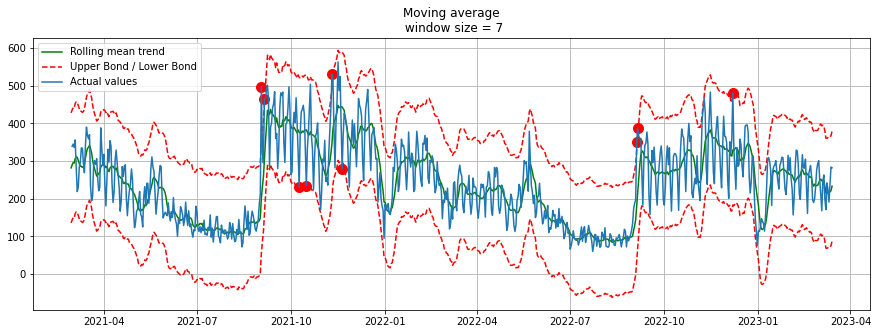

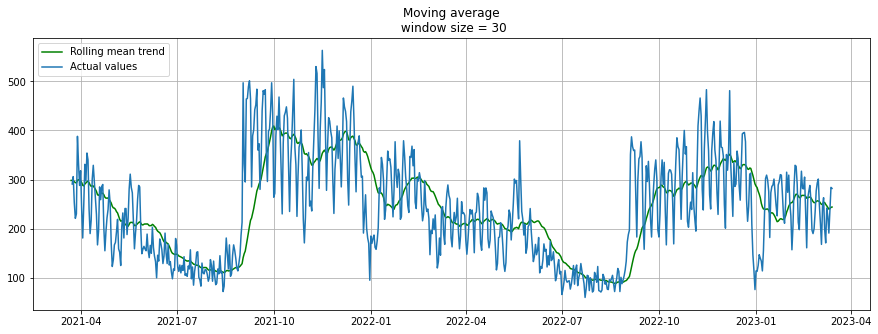

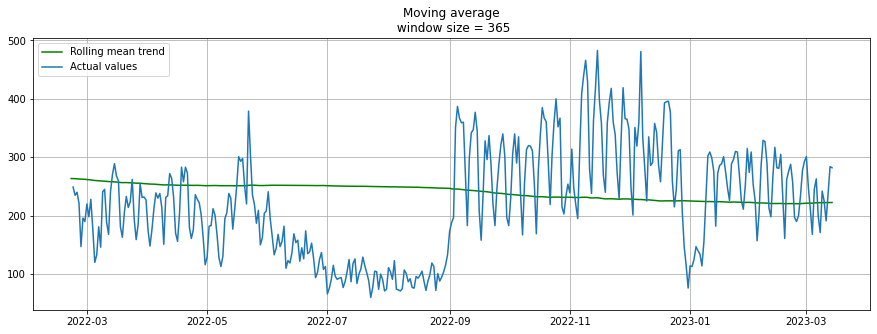

In [ ]:
plotMovingAverage(df, 7, plot_intervals=True, plot_anomalies=True) # сглаживаем по неделям
plotMovingAverage(df, 30) # сглаживаем по месяцам
plotMovingAverage(df, 365) # сглаживаем по годам

Предположения о низходящем тренде числа запросов и сезонности подтверждаются

In [ ]:
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

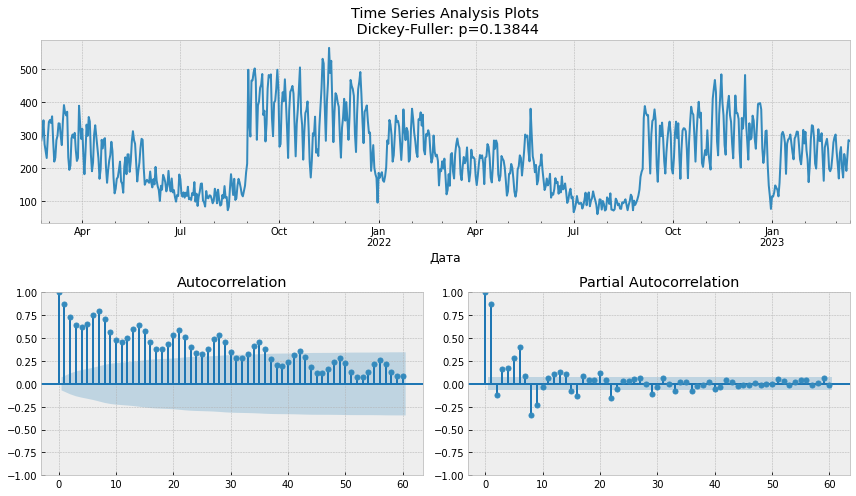

In [ ]:
tsplot(df['Запросы'], lags=60)

Отвергаем гипотезу о стационарности временного ряда, также из графика автокорреляции можем наблюдать недельную сезонность.

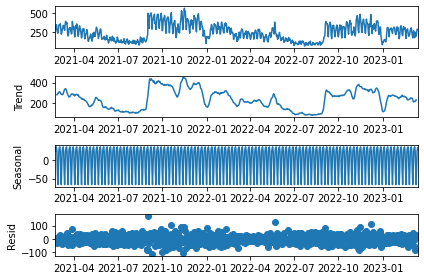

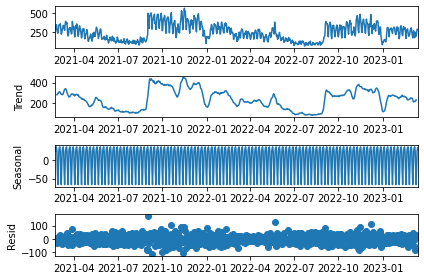

In [ ]:
sm.tsa.seasonal_decompose(df).plot()

Дисперсия остатков уменьшается со временем, чтобы выровнить разброс колебаний выполним логарифмирование временного ряда

In [ ]:
from numpy import log

df_log = df.apply(log)

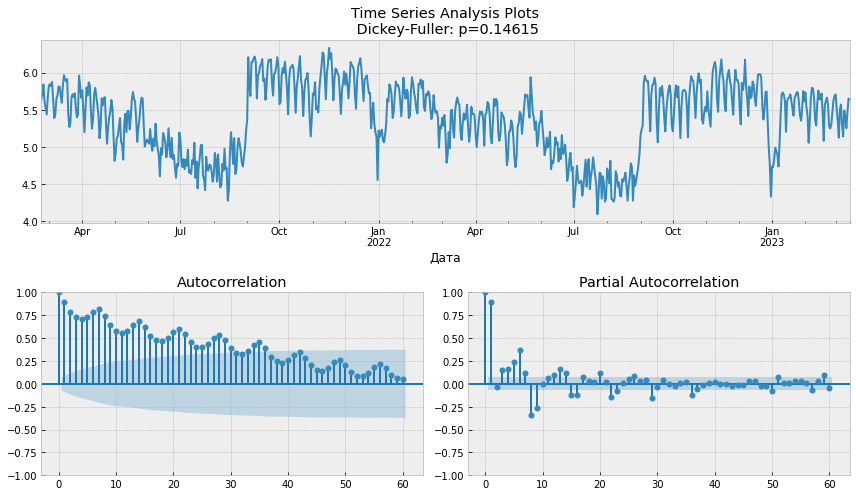

In [ ]:
tsplot(df_log['Запросы'], lags=60)

Уберем влияние сезонности,применив сезонное дифференцирование(недельное).

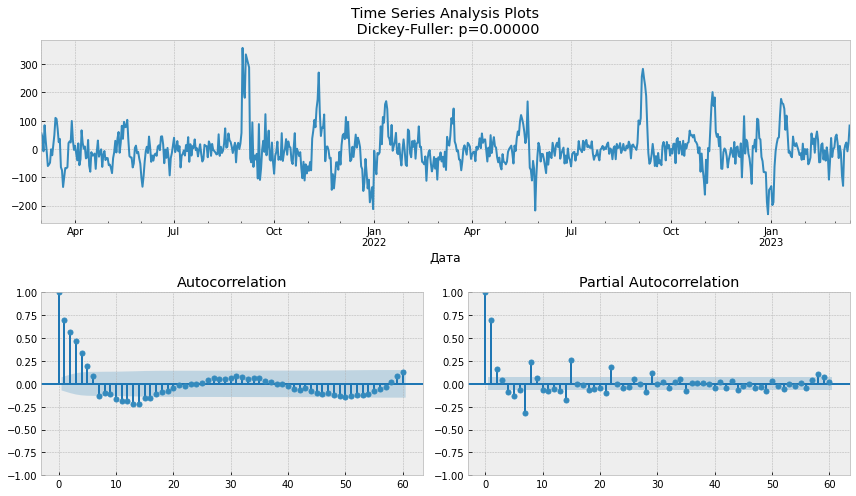

In [ ]:
df_diff = df['Запросы'] - df['Запросы'].shift(7)
tsplot(df_diff[7:], lags=60)

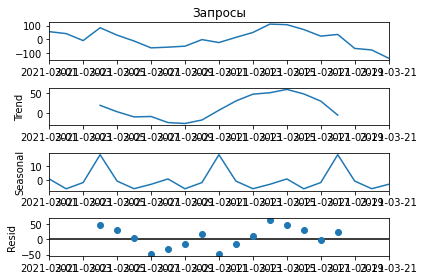

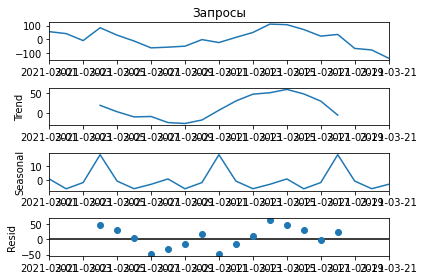

In [ ]:
sm.tsa.seasonal_decompose(df_diff[7:28]).plot()

Значение теста Дики-Фуллера равно нулю, можем принять гипотезу о стационарности ряда. После недельного дифференцирования все равно неблюдаем некую сезонность, возможно у исходного ряда также имеется двух недельная сезонность.

Ряд стационарный, но имеем много значимых выбросов автокорреляции, поэтому применим также и простое дифференцирование.

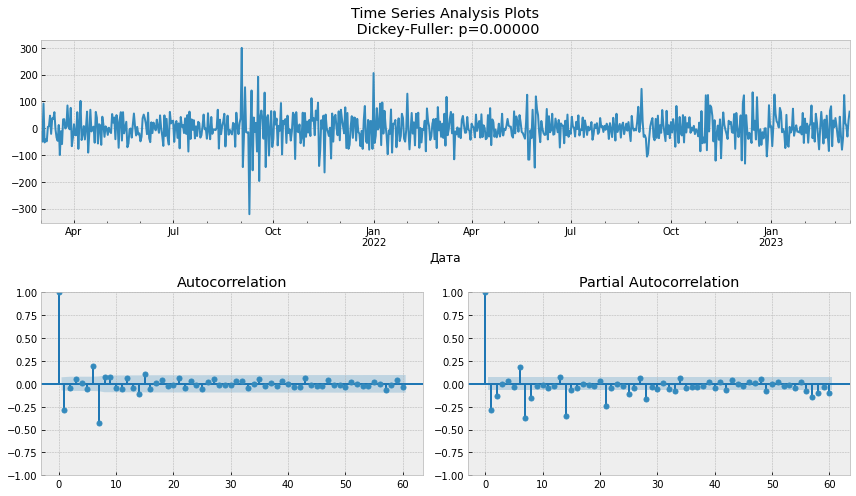

In [ ]:
df_diff = df_diff - df_diff.shift(1)
tsplot(df_diff[7+1:], lags=60)

Определим примерные параметры модели ARIMA:
* d = 1 применяли обычное дифференцирование один раз
* D = 1 применяли сезонное дифференцирование один раз
* s = 7 длина сезона
* p = 6 номер последнего несезонного лага со значимой частичной автокорреляцей
* q = 6 номер последнего несезонного лага со значимой автокорреляцией
* P = 1 номер последнего сезонного лага со значимой частичной автокорреляцией
* Q = 1 номер последнего сезонного лага со значимой автокорреляцией

In [ ]:
# setting initial values and some bounds for them
d=1
D = 1
s =  7
ps = range(4,7)
qs = range(4,7)
Ps = range(1,3)
Qs = range(1,3)

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
from tqdm import tqdm_notebook
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_log, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=False)
        except ValueError:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
        # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_r

CPU times: user 10min 50s, sys: 8min 32s, total: 19min 22s
Wall time: 13min 19s


In [ ]:
p, q, P, Q = result_table.parameters[0]
print(p, q, P, Q)
best_model=sm.tsa.statespace.SARIMAX(df_log, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

5 4 1 2


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                       SARIMAX Results                                        
Dep. Variable:                                Запросы   No. Observations:                  751
Model:             SARIMAX(5, 1, 4)x(1, 1, [1, 2], 7)   Log Likelihood                 324.576
Date:                                Sun, 26 Mar 2023   AIC                           -623.151
Time:                                        17:26:00   BIC                           -563.212
Sample:                                    02-22-2021   HQIC                          -600.046
                                         - 03-14-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0990      0.214     -0.463      0.643      -0.518       0.320
ar.

### Лучшие параметры модели
* ### p = 5
* ### q = 4
* ### P = 1
* ### Q = 2


In [ ]:
# ФУНКЦИЯ ПРЕДСКАЗАНИЯ И ОТРИСОВКИ РЕЗУЛЬТАТА

def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

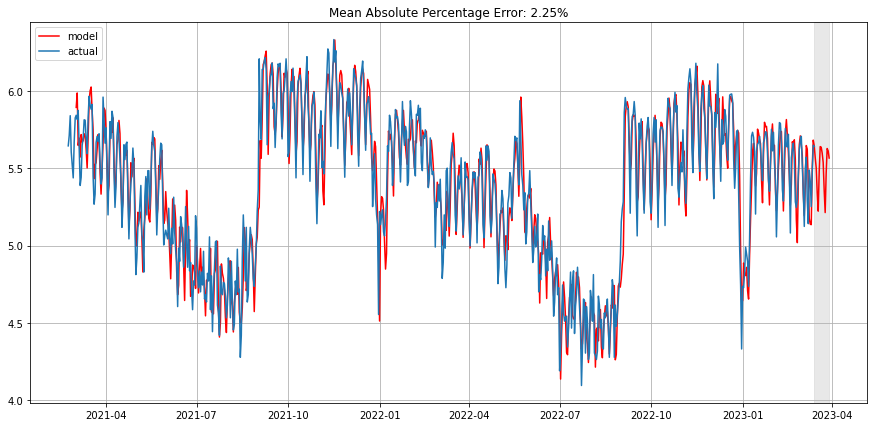

In [ ]:
plotSARIMA(df_log, best_model, 14)

Поскольку применяли логарифмирование,то для нужно экспоненцировать каждое предсказание, чтобы оценить качество относительно реальных данных. Кроме того нужно округлить значения, так как количество запросов - целое число.

In [ ]:
def plotSARIMA(orig, series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

        # adding model values
    data_orig = orig.copy()
    data_orig.columns = ['actual']
    data_orig['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data_orig['arima_model'][:s+d] = np.NaN


    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    print(np.round(np.exp(forecast))[-14:])
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data_orig['actual'][s+d:], np.round(np.exp(data['arima_model'][s+d:])))

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(np.round(np.exp(forecast)), color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data_orig.actual, label="actual")
    plt.legend()
    plt.grid(True)

2023-03-16    245.0
2023-03-17    209.0
2023-03-18    185.0
2023-03-19    240.0
2023-03-20    282.0
2023-03-21    281.0
2023-03-22    270.0
2023-03-23    254.0
2023-03-24    212.0
2023-03-25    184.0
2023-03-26    237.0
2023-03-27    278.0
2023-03-28    274.0
2023-03-29    262.0
dtype: float64


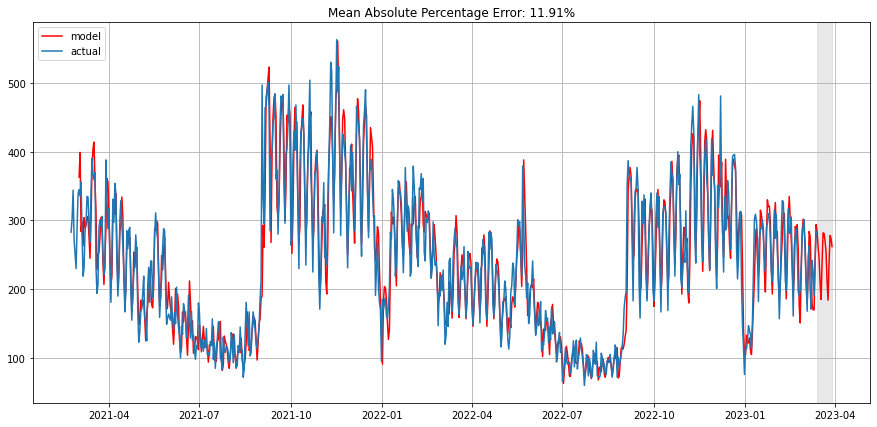

In [ ]:
plotSARIMA(df, df_log, best_model, 14)

**Лучший результат оценки MAPE равен 12%.**
В среднем модель ошибается в предсказании от реальных значений на 12%.
Применение логарифмирования и подбор оптимальных параметров модели ARIMA позволили снизить ошибку с **16% до 12%.**